<a href="https://colab.research.google.com/github/SoumyaShreeram/Microlensing_with_NeuralNets/blob/master/08_Testing_NNs_on_light_curves_with_Gaussian_Processes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Testing Neural Networks on Light Curves with Gaussian Processes
Author: Soumya Shreeram <br>
Date: 15th May 2020

Import all required python libraries

In [0]:
from google.colab import drive
import os
import pickle
import importlib
import itertools

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import random
import os
from IPython.display import Image, SVG
from scipy.interpolate import interp1d 

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import sklearn.gaussian_process as gp
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, RationalQuadratic
from sklearn.gaussian_process.kernels import ConstantKernel

%tensorflow_version 1.x
import tensorflow as tf

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Activation, InputSpec
from tensorflow.python.keras.layers import Conv1D, Conv2D
from tensorflow.python.keras.layers import MaxPooling1D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Add, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer

Mount google drive

In [30]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Directory where the `python` files are stored on Google Drive. These imported files are also available in `.ipynb` format on the GitHub repo with same names (without the dr; <strike>`dr`</strike>`0X_sameFileName`). dr stands for drive. 

In [0]:
os.chdir('/content/gdrive/My Drive/Colab Notebooks')

import nb_02i_preprocessing_data as dat
import nb_03_neural_network_designs as nnet

Setting up the path to the data directory

In [0]:
current_dir = os.getcwd()
data_dir = r'/content/gdrive/My Drive/training_set_microlensing/'
save_image_dir = r'/content/gdrive/My Drive/Colab Notebooks/Images/'
save_model_dir = r'/content/gdrive/My Drive/Colab Notebooks/Models/'
save_data_dir = r'/content/gdrive/My Drive/Colab Notebooks/Data/'

### 1. Input parameters

In [0]:
v_t = [500, 300] # transverse velcity
v_t_idx = 0 # choose index value for the velocity you would like (0 or 1)
r_0 = (2,4,10,15,20,30,40,60,80,100) # scale radius
output_class_names = [str(r) for r in r_0 ]

# select type of Interpolation
cubic, linear = False, True

# data loaded with season gaps
season_gaps = True

# if using the new data set generated by Eric (v_500_new, v_500_gaps_new)
new_data_set = True

# generates new interpolated light curves? OR Use previously saved light curves?
generate_new_files, use_saved_file = False, True

### 2. Load the data

There are 10 categories into which the light-curves are classified. Each category is represented by the scale radius `r_0`. For every scale radius, there exists a light-curve whose data points are stored in the 3D array `l_curves`.

In [34]:
# sets the sampling parameters
sample_params = dat.setSamplingParameters(v_t[v_t_idx], data_dir, season_gaps)

# initializes data arrays
class_cat, l_curves, out_catergories, out_radii = dat.initializer(r_0, \
                                                                  sample_params)

for idx, rad in enumerate(r_0):
  filename = dat.getFilename(data_dir, idx, rad, v_t[v_t_idx], sample_params, \
                             season_gaps, new_data_set)
  
  # load data from the file
  l_curves, mjhd, mjhd_err = dat.loadData(filename, idx, l_curves, sample_params, idx,\
                                  season_gaps, new_data_set)
  out_catergories[idx*sample_params[0][idx]:(idx+1)*sample_params[0][idx]] = class_cat[1][idx]
  out_radii[idx*sample_params[0][idx]:(idx+1)*sample_params[0][idx]] = r_0[idx]

print('Shape of light curves vector:', np.shape(l_curves))

Shape of light curves vector: (50000, 955, 1)


#### 2.1 Load the light curves interpolated using Gaussian Processes

In [35]:
# initializing a light curve array to store the gaussian proccesses regressed curves
l_curves_gpr = np.array([])
l_curves_gpr.shape = (0, len(l_curves[0,:,0]),1)

# loads the file
filename = 'Light_Curves/lcurves_SeasonGaps_GPR_%d'%len(l_curves)
l_curves_gpr = dat.loadFile(data_dir,filename)

# prints the light curves shape
dat.printLcurvesShape(l_curves_gpr) 

shape of light curves arrays: (50000, 955, 1)


#### 2.2 Plots of some random light-curves

4.0 2.0


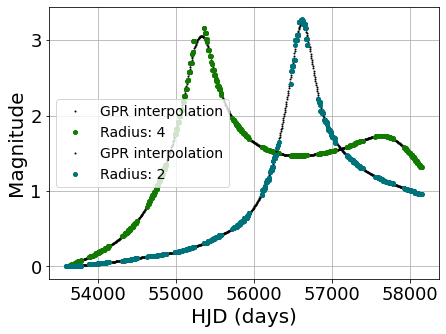

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
n = [9999, 2600]
colors = ['#127a00',  '#00727a', '#888894']

# original and reshuffled time-array
mjhd = np.load(data_dir+'Light_Curves/mjhd.npy')
mjhd_gpr = np.linspace(mjhd[0], mjhd[-1], num=len(mjhd))

for i, num in enumerate(n):
  # light curves with GP interpolation
  ax.plot(mjhd_gpr, l_curves_gpr[n[i], :, 0], '.', color='k', label='GPR interpolation', markersize=2)

  # without interpolation
  ax.plot(mjhd, l_curves[n[i], :], '.', color=colors[i], label='Radius: %i'%(out_radii[n[i]]), markersize=8)

dat.setLabels(ax, 'HJD (days)', 'Magnitude', ticks=True, legend=True)
fig.savefig(save_image_dir+'/interpolated_lcurves.png') 

print(out_radii[9900], out_radii[2600])

### 4. Generate training and testing data sets

Proceeding with linear interpolation.

In [0]:
train_l_curves, test_l_curves, onehot_train, onehot_test, train_radii, \
test_radii  = dat.generateTestTrain(l_curves_gpr, out_catergories, out_radii, r_0)

trainX, trainy, testX, testy = train_l_curves, onehot_train, test_l_curves, onehot_test

### 4. Compiling the 3 networks

The three networks compiled here are coded in `03_Neural_Network_Designs.ipynb` that have been saved as `nb03_Neural_Network_Designs.py`, for ease of importing it. The python files can be found in the GitHub repo folder *python files*. 

Note that if you are running this from colab, need to have these `.py` files in your drive folder *Colab Notebooks*. 

The three networks are the Convolutional Neural Network (**CNN**), Residual Neural Network with 7 layers (**ResNet7**), and the Residual Neural Network with 18 layers (**ResNet18**).

Default constants that can be modified.

In [38]:
# choose one of these networks to use by setting the boolean to True and rest to False
CNN, ResNet7, ResNet18 = False, False, True

model_types = [CNN, ResNet7, ResNet18]
model_name_list = ['CNN','ResNet7', 'ResNet18']

for i in range(len(model_name_list)):
  if model_types[i]:
    model_name = model_name_list[i]
print('Using the Neural Network:', model_name)

Using the Neural Network: ResNet18


The following code block uses the methods defined in the file `dr04_Neural_Network_Designs.py`: imported as **`nnet`**

Model parameters are defined in the methods in **`nnet`** additionally some more details:
* `num_hidden_nodes`: number of nodes in hidden fully connected layer
*`dropout_ratio`: % of nodes in the hidden layer to dropout during back-propagation update of the network weights

#### 4.1 Compiling CNN

In [0]:
if CNN:
  # reloads the file if any changes are made
  importlib.reload(nnet)

  # CNN model parameters
  num_filter = (32, 32, 44, 44)
  kern_size = (21,21,15,15)
  maxpoolsize = (None, 15, None, 15)
  shortcut_link = (0,1,2,3)
  batch_norm = False
  dropout_ratio = 0.4  
  sampling = 3
  num_pieces = 1
  num_hidden_nodes = 1500
  
  # build the model
  inputs, outputs = nnet.buildCNN(sample_params[2], num_filter, kern_size, maxpoolsize, \
                                  num_hidden_nodes, dropout_ratio, r_0)
  
  # optimization, compilation parameters
  optimizer_type = Adam(lr=5e-4)  
  loss = 'categorical_crossentropy'  
  metrics = ['categorical_accuracy'] 

  # compiles the model
  model = nnet.compileDisplayNetwork(inputs, outputs, optimizer_type, loss, \
                                    metrics, save_image_dir+'CNN', True)
    
  print('Network created')

#### 4.2 Compiling ResNet-7

In [0]:
if ResNet7:
  # reloads the file if any changes are made
  importlib.reload(nnet)

  # CNN model parameters
  num_filter = (32, 32, 44, 44)
  kern_size = (21,21,15,15)
  maxpoolsize = (None, 15, None, 15)
  shortcut_link = (0,1,2,3)
  batch_norm = False
  dropout_ratio = 0.4  
  sampling = 3
  num_pieces = 1
  num_hidden_nodes = [1500]
  
  # prepare data with sample cuts with the correct shape
  testX_prep = nnet.prepareDataSampleCuts(testX, sampling, num_pieces)
  trainX_prep = nnet.prepareDataSampleCuts(trainX, sampling, num_pieces)

  # build the model
  inputs, outputs = nnet.buildResNet7(num_filter, kern_size, \
                                                  maxpoolsize, num_hidden_nodes[0], \
                                                  dropout_ratio, shortcut_link, \
                                                  batch_norm, trainX_prep.shape[1], r_0)
  
  # optimization, compilation parameters
  optimizer_type = Adam(lr=5e-4)  
  loss = 'categorical_crossentropy'  
  metrics = ['categorical_accuracy'] 

  # compiles the model
  model = nnet.compileDisplayNetwork(inputs, outputs, optimizer_type, loss, \
                                    metrics, save_image_dir+'ResNet-7', do_print_summary = False)
    
  print('Network created')

### 4.3 Compiling ResNet-18

In [41]:
if ResNet18:
  # reloads the file if any changes are made
  importlib.reload(nnet)

  # ResNet model parameters
  num_filter = (32, 32, 32)
  kern_size = (10,20,50)
  n_block = 5
  maxpoolsize = 3
  num_hidden_nodes =[1000.0,]
  dropout_ratio = 0.7 
  batch_norm = True
  sampling = 1
  num_pieces = 1

  # build network
  inputs, outputs = nnet.buildResNet18(sample_params[2], num_filter, kern_size, n_block, \
                                 maxpoolsize, num_hidden_nodes, dropout_ratio, r_0,\
                                 batch_norm)
  
  # ResNet compilation parameters
  learning_rate = 1e-4
  max_epochs = 80
  decay = learning_rate/max_epochs
  optimizer_type = Adam(lr=learning_rate, decay=decay)  
  loss = 'categorical_crossentropy'  
  metrics = ['categorical_accuracy'] 

  # compiles network
  model = nnet.compileDisplayNetwork(inputs, outputs, optimizer_type, loss, \
                                     metrics,save_image_dir+'ResNet-18', True)
  
  #model.load_weights('/content/gdrive/My Drive/Colab_Notebooks/Deep_learning_for_optical_IMaging/Resnet_weights.h5')
  print('Network created')

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 955, None, 1 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 955, None, 32 352         input_3[0][0]                    
__________________________________________________________________________________________________
activation_23 (Activation)      (None, 955, None, 32 0           conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 955, None, 32 20512       activation_23[0][0]              
____________________________________________________________________________________________

### 5. Training the network

Constants used for training the network

In [0]:
validation_split_ratio = 0.2  # % of the seen dataset to be put aside for validation, rest is for training
max_epochs = 50  # maxmimum number of epochs to be iterated
batch_size = 60   # batch size for the training data set
num_inputs = 1
verbose = 1

In [43]:
if ResNet7:
  # reshaped data is used while training
  trainX = trainX_prep
  testX = testX_prep

# trains the model
model, model_history = nnet.trainModel(model, trainX, trainy, batch_size, max_epochs,\
                                  validation_split_ratio, verbose)

# evaluates and predicts the results from the trained model
results, predictions = nnet.evaluatePredictModel(model, testX, testy, verbose = 1) 

print('[test loss, test acc] = ', results)

Train on 32000 samples, validate on 8000 samples
Epoch 1/50
32000/32000 [==============================] - 11s 345us/sample - loss: 2.2090 - categorical_accuracy: 0.1978 - val_loss: 1.7866 - val_categorical_accuracy: 0.2845
Epoch 2/50
32000/32000 [==============================] - 10s 321us/sample - loss: 1.8131 - categorical_accuracy: 0.2702 - val_loss: 1.7348 - val_categorical_accuracy: 0.3026
Epoch 3/50
32000/32000 [==============================] - 10s 318us/sample - loss: 1.7344 - categorical_accuracy: 0.3094 - val_loss: 1.6855 - val_categorical_accuracy: 0.3371
Epoch 4/50
32000/32000 [==============================] - 10s 319us/sample - loss: 1.6812 - categorical_accuracy: 0.3359 - val_loss: 1.6219 - val_categorical_accuracy: 0.3614
Epoch 5/50
32000/32000 [==============================] - 10s 320us/sample - loss: 1.6482 - categorical_accuracy: 0.3511 - val_loss: 1.5854 - val_categorical_accuracy: 0.3923
Epoch 6/50
32000/32000 [==============================] - 10s 320us/sample -

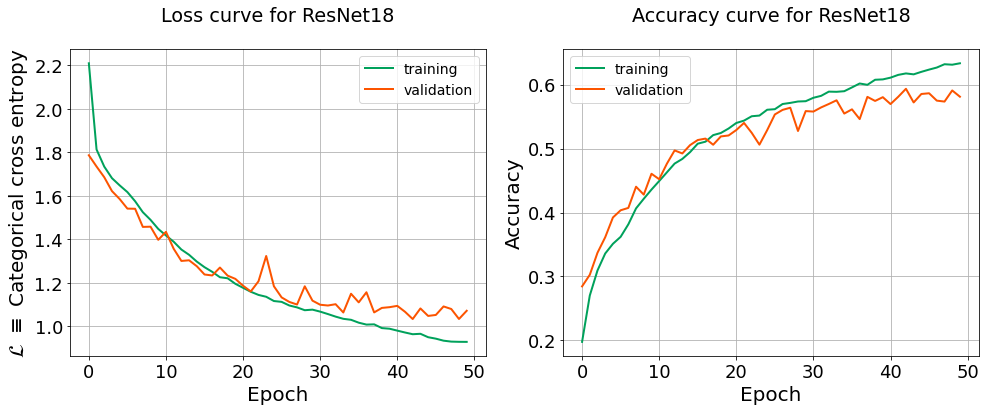

In [45]:
# plots the history
fig, ax = plt.subplots(1,2, figsize=(14,6))
labels = ['training', 'validation']
loss_Accuracy = ['loss', 'val_loss', 'categorical_accuracy', 'val_categorical_accuracy']

model_history = model_history.history
dat.plotLoss(ax[0], model_history, loss_Accuracy, model_name, labels)
dat.plotAccuracy(ax[1], model_history, loss_Accuracy, model_name, labels)
 
fig.savefig(save_image_dir+'/LandA_GPinter%s_epochs_%d.png'%(model_name, max_epochs))    
fig.tight_layout()

In [0]:
data = [model_history[loss_Accuracy[0]], model_history[loss_Accuracy[1]], model_history[loss_Accuracy[2]], model_history[loss_Accuracy[3]]]

# saves the loss and accuracy curves
filename = save_data_dir+'SeasonGaps_GP_%s.npy'%model_name
with open(filename, 'wb') as f:
  np.save(f, data, allow_pickle=True)

### 6. Displaying the classification report, confusion matrix

In [46]:
y_predict = np.argmax(predictions, axis=1)
y_test = np.argmax(testy, axis=1)

print('Test set classification report:\n')
print(classification_report(y_test, y_predict, target_names=output_class_names))

Test set classification report:

              precision    recall  f1-score   support

           2       0.83      0.79      0.81      1005
           4       0.77      0.75      0.76       972
          10       0.71      0.64      0.68      1025
          15       0.70      0.47      0.56       989
          20       0.50      0.67      0.57       960
          30       0.59      0.44      0.50      1039
          40       0.48      0.54      0.51       979
          60       0.46      0.72      0.56      1031
          80       0.35      0.33      0.34      1019
         100       0.43      0.34      0.38       981

    accuracy                           0.57     10000
   macro avg       0.58      0.57      0.57     10000
weighted avg       0.58      0.57      0.57     10000



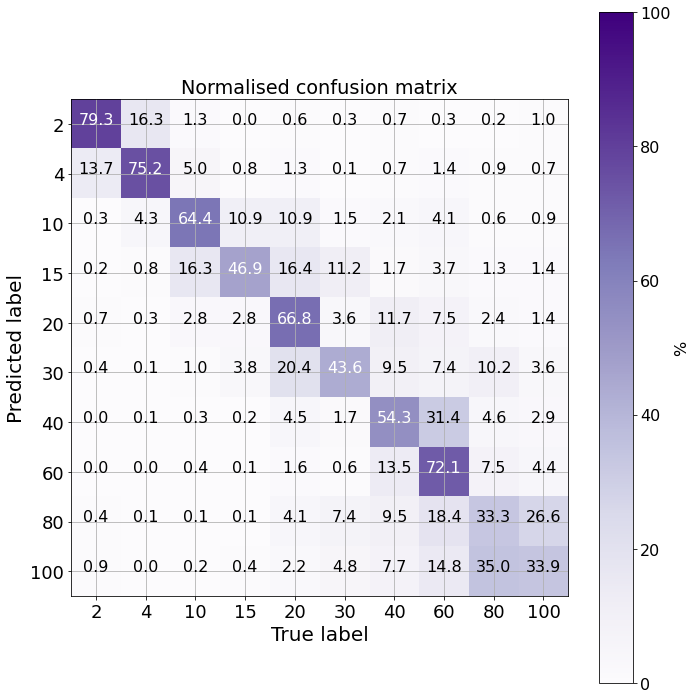

In [47]:
# need this to avoid callback errors
from sklearn.metrics import confusion_matrix
importlib.reload(dat)

# generate confusion matrix
cfm = confusion_matrix(y_test, y_predict)  

# row normalisation of confusion matrix
cfm_probability = cfm.astype('float')/cfm.sum(axis=1)[:, np.newaxis]  
# confusion probability matrix
cfm_probability = cfm_probability * 100.0  

fig, ax = plt.subplots(1,1, figsize=(10,10))
dat.plotConfusionMatrix(ax, cfm_probability, output_class_names, 3)

# save figure
fig.savefig(save_image_dir+'/cfm_%s_epochs_%d_GPInter.png'%(model_name, max_epochs))    
fig.tight_layout()